In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from dotenv import load_dotenv
import numpy as np
import os

%matplotlib inline

In [2]:
N_QUBITS = 5

# Randomly mark values
size = np.random.randint(1, N_QUBITS + 1)
MARKED_LIST = [21]
SHOTS = 2**16
# MARKED_LIST = np.random.choice(range(2**N_QUBITS), size, replace=False).tolist()

# print the marked values in big-endian format (leftmost is qubit 0) / same format as in the histogram
print("Marked values:", sorted(
    [f"|{format(x, f'0{N_QUBITS}b')[::-1]}⟩" for x in MARKED_LIST]
))

Marked values: ['|10101⟩']


In [3]:
def initialize_superposition(qc: QuantumCircuit, qr: QuantumRegister):
    """
    Initialize the quantum register in a superposition state.
    This function applies Hadamard gates to all qubits in the quantum register.
    """
    qc.h(qr)

In [4]:
qr_data = QuantumRegister(N_QUBITS, name='q')
cr_data = ClassicalRegister(N_QUBITS, name='cr')
quantum_circuit = QuantumCircuit(qr_data, cr_data) # Grover's curcuit

initialize_superposition(quantum_circuit, qr_data)

quantum_circuit.draw()

┌───┐
 q_0: ┤ H ├
      ├───┤
 q_1: ┤ H ├
      ├───┤
 q_2: ┤ H ├
      ├───┤
 q_3: ┤ H ├
      ├───┤
 q_4: ┤ H ├
      └───┘
cr: 5/═════

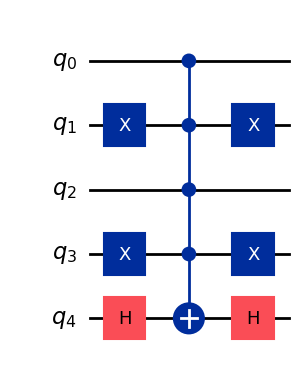

In [5]:
# Setup Oracle
def create_oracle(qr: QuantumRegister) -> QuantumCircuit:
    """
    Create the oracle for Grover's algorithm.
    The oracle marks the states that are part of the MARKED_LIST by flipping the sign of their amplitudes.
    """
    oracle = QuantumCircuit(qr, name='oracle')
    for m in MARKED_LIST:
        bits_m = format(m, f'0{N_QUBITS}b')
        
        for idx, bit in enumerate(bits_m):
            if bit == '0':
                oracle.x(qr[idx])
        oracle.h(qr[N_QUBITS - 1])
        oracle.mcx(list(qr[: N_QUBITS - 1]), qr[N_QUBITS - 1])
        oracle.h(qr[N_QUBITS - 1])
        for idx, bit in enumerate(bits_m):
            if bit == '0':
                oracle.x(qr[idx])

    oracle.draw('mpl')
    oracle = oracle.to_gate()
  
    return oracle

oracle = create_oracle(qr_data)

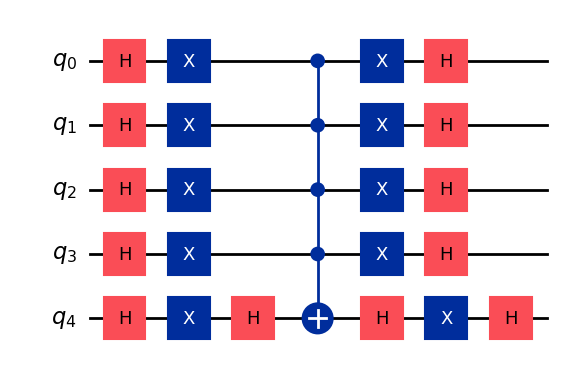

In [6]:
# Defuser
def create_diffuser(qr: QuantumRegister, num_bits: int) -> QuantumCircuit:
    """
    Create a diffuser circuit for Grover's algorithm.
    The diffuser amplifies the probability of the marked states.
    """
    diffuser = QuantumCircuit(qr, name='diffuser')
    diffuser.h(qr)
    diffuser.x(qr)

    diffuser.h(qr[num_bits - 1])
    diffuser.mcx(list(qr[: num_bits - 1]), qr[num_bits - 1])
    diffuser.h(qr[num_bits - 1])
    
    diffuser.x(qr)
    diffuser.h(qr)

    diffuser.draw('mpl')
    return diffuser.to_gate()

diffuser = create_diffuser(qr_data, N_QUBITS)

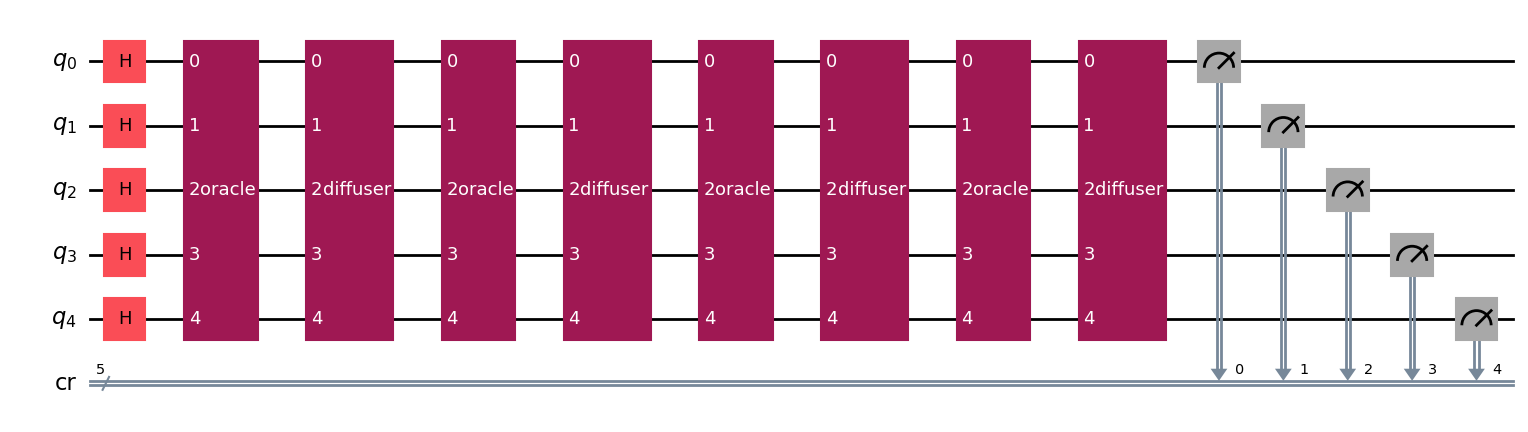

In [7]:
target_amount = len(MARKED_LIST)
N = 2**N_QUBITS
k = int(np.floor((np.pi / 4) * np.sqrt(N / target_amount))) 

for _ in range(k):
    quantum_circuit.append(oracle, qr_data)
    quantum_circuit.append(diffuser, qr_data)

for i in range(N_QUBITS):
    quantum_circuit.measure(qr_data[i], cr_data[i])

_ = quantum_circuit.draw('mpl')

In [8]:
load_dotenv()

provider = QiskitRuntimeService(
    channel="ibm_quantum",
    instance="ibm-q/open/main",
    token= os.getenv("IBM_QUANTUM_API_KEY")
)

ibm_backend = provider.backend("ibm_brisbane")

real_backend = ibm_backend 
simulation_backend = AerSimulator.from_backend(real_backend)

C:\Users\mi6o_\AppData\Local\Temp\ipykernel_36676\3457817491.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  provider = QiskitRuntimeService(


In [9]:
def run_simulation():
    qc_compiled = transpile(quantum_circuit, simulation_backend)
    sampler = Sampler(simulation_backend)
    job_sim = sampler.run([qc_compiled], shots=SHOTS)
    result_sim = job_sim.result()
    
    return result_sim

In [10]:
def run_on_real_backend():
    qc_compiled = transpile(quantum_circuit, real_backend)
    sampler = Sampler(real_backend)
    job_sim = sampler.run([qc_compiled], shots=SHOTS)
    result_sim = job_sim.result()
    
    return result_sim

Marked values: ['|10101⟩']


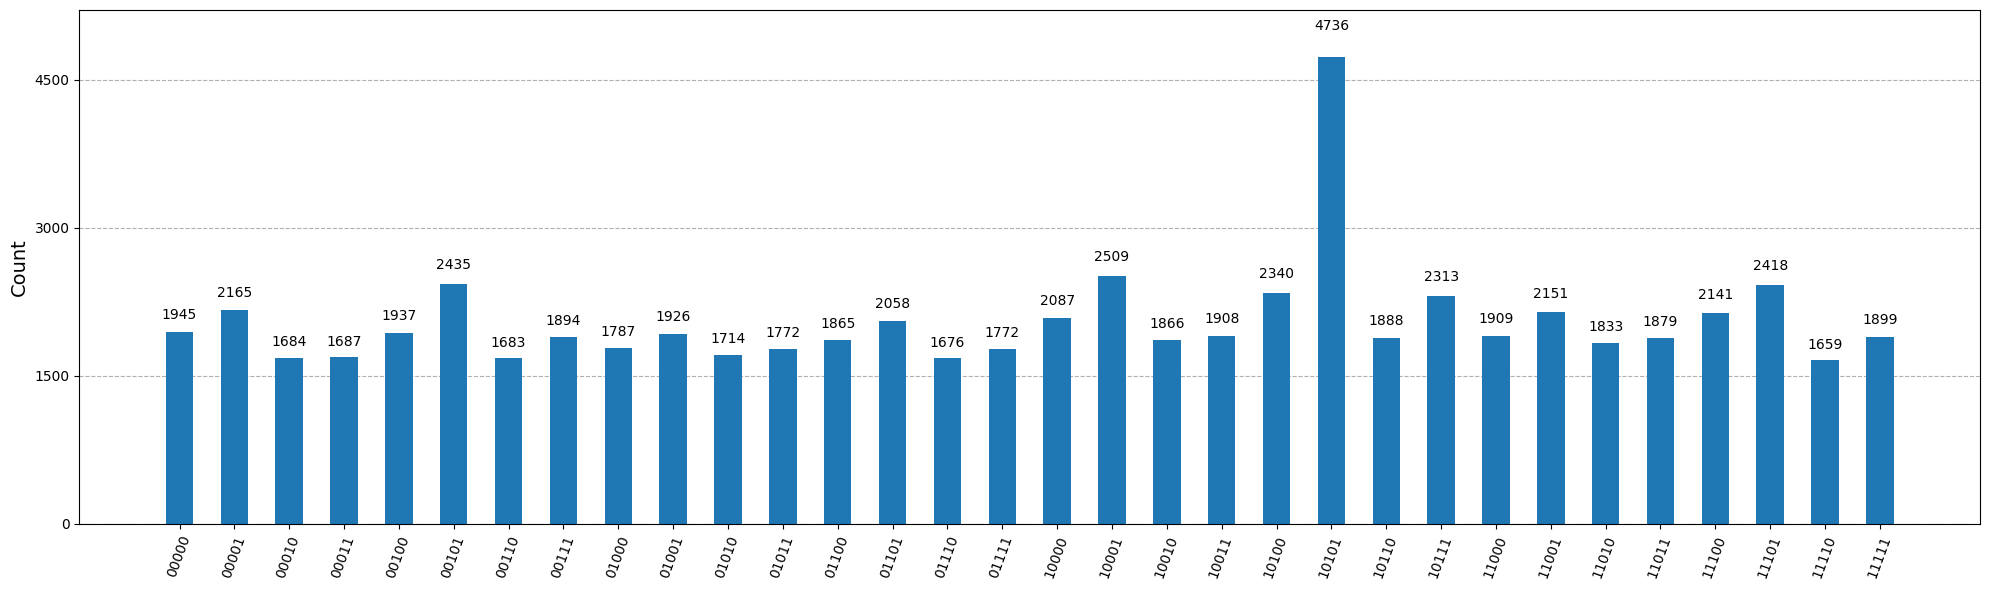

In [11]:
simulation_measurements_bitstrings = run_simulation()[0].data.cr.get_bitstrings()
sim_counts = {}

for bitstring in simulation_measurements_bitstrings:
    sim_counts[bitstring] = sim_counts.get(bitstring, 0) + 1

print("Marked values:", sorted(
    [f"|{format(x, f'0{N_QUBITS}b')[::-1]}⟩" for x in MARKED_LIST]
))

_ = plot_histogram(sim_counts, figsize=(20, 6))


d:\Projects\2nd semester\qic-project\.venv\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:1111: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


Marked values: ['|10101⟩']


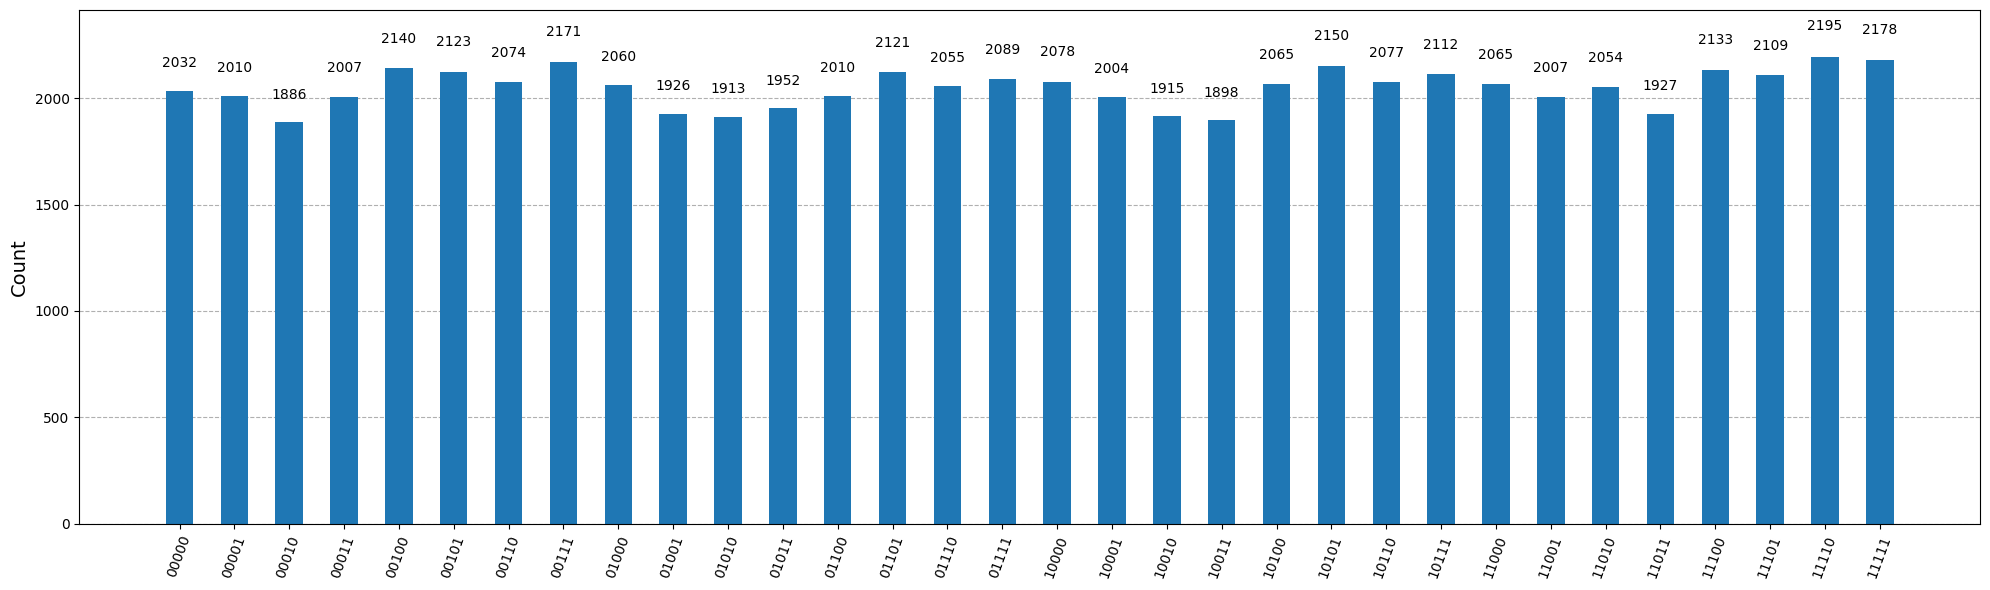

In [12]:
raw_measurements_bitstrings = run_on_real_backend()[0].data.cr.get_bitstrings()
counts = {}

for bitstring in raw_measurements_bitstrings:
    counts[bitstring] = counts.get(bitstring, 0) + 1

print("Marked values:", sorted(
    [f"|{format(x, f'0{N_QUBITS}b')[::-1]}⟩" for x in MARKED_LIST]
))

_ = plot_histogram(counts, figsize=(20, 6))

In [13]:
counts

{'00000': 2032,
 '01111': 2089,
 '00111': 2171,
 '10001': 2004,
 '00110': 2074,
 '10101': 2150,
 '00010': 1886,
 '11010': 2054,
 '01000': 2060,
 '10011': 1898,
 '01101': 2121,
 '01001': 1926,
 '01011': 1952,
 '10111': 2112,
 '01110': 2055,
 '01100': 2010,
 '11001': 2007,
 '00001': 2010,
 '10000': 2078,
 '11110': 2195,
 '11101': 2109,
 '00011': 2007,
 '11111': 2178,
 '11100': 2133,
 '00101': 2123,
 '01010': 1913,
 '00100': 2140,
 '11011': 1927,
 '10110': 2077,
 '10100': 2065,
 '11000': 2065,
 '10010': 1915}